## Analysis of Netflix Movie and TV Data
### Jonah Trani

---

## Introduction
Netflix is a streaming service that offers a plethora of movies and TV shows which can be accessed through a monthly fee. Over the past decade, this platform has completely revolutionized the way in which consumers view content. Before Netflix, many consumers rented DVDs, VHS tapes, or simply watched live television over cable. Now with the power of streaming, consumers can watch TV with ease on their mobile device. As of October 2020, there are [195 million subscribers to Netflix](https://s22.q4cdn.com/959853165/files/doc_financials/2020/q3/FINAL-Q3-20-Shareholder-Letter.pdf) , with 73 million in the US alone.

For the purposes of this analysis, we will be looking at a data table collected by [Flixable](https://www.kaggle.com/shivamb/netflix-shows) to look at what kinds of film genre and type Netflix has added to its platform over the years. Later on, we will conjoin this data with [IMDB ratings](https://www.kaggle.com/stefanoleone992/imdb-extensive-dataset?select=IMDb+ratings.csv) to also look at the different ratings of shows Netflix has over time, and finally look at Netflix Originals specifically to see how they fare with the trends.

---

## Data Collection
The first step in the data science pipeline is to collect our data. We will be using a number of useful Python 3 libraries including pandas, numpy, matplotlib, seaborn, and sckit-learn. These are all great tools for data sctructures, manipulation, and visualization. 

In [202]:
## Import some basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

In [176]:
## Load in Netflix data
df_netflix = pd.read_csv('netflix_titles.csv')
df_netflix.count()

show_id         6234
type            6234
title           6234
director        4265
cast            5664
country         5758
date_added      6223
release_year    6234
rating          6224
duration        6234
listed_in       6234
description     6234
dtype: int64


---

## Data Processing
Now that we've brought in our dataset, we need to tidy it and take care of any missing data. Here we will be bringing in a second dataset in order to also analyze the ratings of the movies and TV shows, so in order to do that we will have to merge the two datasets. Pandas .merge() allows us to define what type of merge we want, and based on what parameters we would like the two datasets to merge on. For this analysis, we will be using the year and title to grab both the weighted average IMDb rating, as well as the genre of all the content available on Netflix.

In [177]:
df_movierat = pd.read_csv("IMDb_movies.csv", usecols = ['year','genre','avg_vote','title'])
df_movierat.columns

C:\Users\Jonah\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Index(['title', 'year', 'genre', 'avg_vote'], dtype='object')

In [178]:
# Looking at ratings of movies on Netflix
df_netflixrating = df_netflix.merge(df_movierat, how = 'inner', left_on = ['title','release_year'], right_on = ['title','year'])
df_netflixrating.count()

show_id         493
type            493
title           493
director        491
cast            493
country         489
date_added      493
release_year    493
rating          493
duration        493
listed_in       493
description     493
year            493
genre           493
avg_vote        493
dtype: int64

Now that we've combined our two datasets, we can drop any columns that we won't be using in this analysis.

In [179]:
# Drop columns to ones that we will be working with
df_netflixrating = df_netflixrating.drop(['release_year','director','show_id','cast','description'],axis = 1)

Now that we're left with all the columns that we need for our analysis, we need to see what data is missing and take care of it. For this dataset, there is only 4 entries that are missing country data for each one, so we will just remove those rows from the table.

In [180]:
# Find and count all NaN values for each column
df_netflixrating[df_netflixrating.columns[df_netflixrating.isnull().any()]].isnull().sum()
##Since it's only four, we will just drop these entries from the table.
df_netflixrating = df_netflixrating.dropna()
# Drop entries with missing data
df_netflixrating.count()

type          489
title         489
country       489
date_added    489
rating        489
duration      489
listed_in     489
year          489
genre         489
avg_vote      489
dtype: int64


---

## Exploratory Data Analysis
With all our data ready to go, the next step is to look at our data and see if we can find any trends. From our data collection, we have a table that looks at data of movies and TV shows available on Netflix and another of just movies on Netflix with their ratings. Lets look at the number of movies and TV shows available on Netflix. To do this, we will be using the seaborn's .countplot() feature.

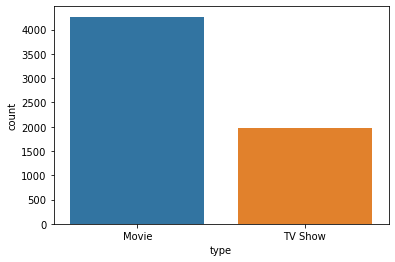

In [181]:
sns.countplot(x = "type", data = df_netflix)

This graph looks at the breakdown by rating.

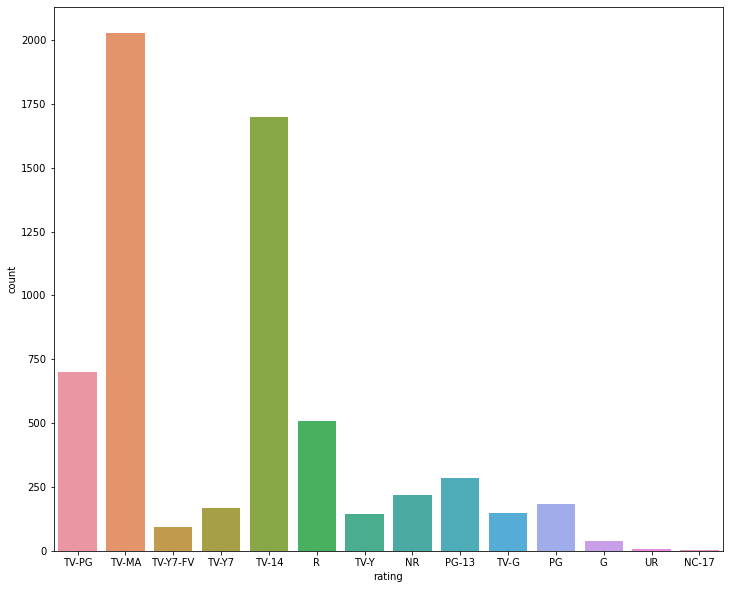

In [182]:
plt.figure(figsize=(12,10))
sns.countplot(x = "rating", data = df_netflix)

Breaking it down even further, we can see the breakdown of movie vs TV show for each rating.

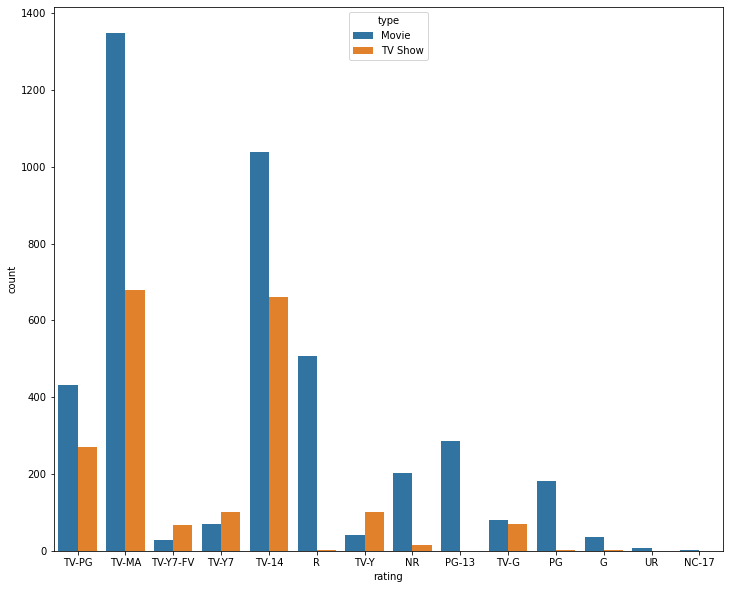

In [183]:
plt.figure(figsize=(12,10))
sns.countplot(x = "rating", hue = "type", data = df_netflix)

Furthermore, lets take the column "date_added" and break that down into the month and year that Netflix added the piece to Netflix. We can break this apart using simple python string manipulation and a mapping function to create two new columns.

In [184]:
year = df_netflix.dropna(subset = ["date_added"])
year['year'] = year["date_added"].apply(lambda x: x.split(', ')[1])
year['month'] = year["date_added"].apply(lambda x: x.lstrip().split(" ")[0])

<ipython-input-184-d953251e7f06>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  year['year'] = year["date_added"].apply(lambda x: x.split(', ')[1])
<ipython-input-184-d953251e7f06>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  year['month'] = year["date_added"].apply(lambda x: x.lstrip().split(" ")[0])


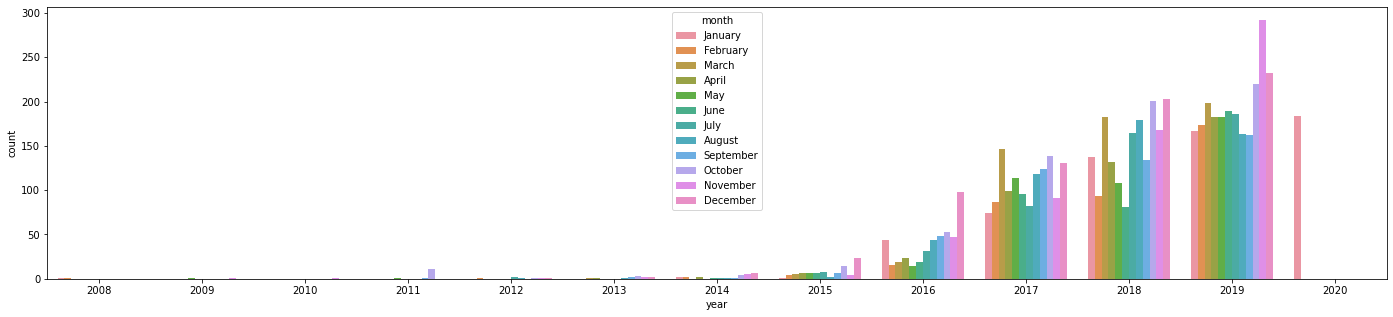

In [185]:
plt.figure(figsize= (24,5))
sns.countplot(x = "year", hue = "month", hue_order = ["January","February","March","April",
                                                      "May","June","July","August","September","October","November","December"],
              data = year)

In this graph, we will be looking at the countries that produced the most movies and TV shows that are on Netflix. To do this, we must first count up the values of each country, and then we can sort them.

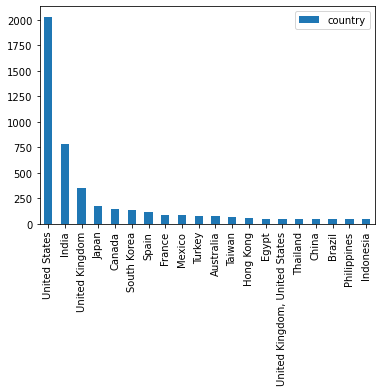

In [186]:
country=df_netflix['country'].value_counts().sort_values(ascending=False)
country = pd.DataFrame(country)
country = country[0:20]
country.plot(kind= "bar")

Now more looking towards our second joint dataset between Netflix Movies and IMDb ratings, we can graph the ratings based on when the movie was added.

In [187]:
df_yearrat = year.merge(df_movierat, how = 'inner', left_on = ['title','release_year'], right_on = ['title','year'])
df_yearrat = df_yearrat.dropna()
df_yearrat.columns

Index(['show_id', 'type', 'title', 'director', 'cast', 'country', 'date_added',
       'release_year', 'rating', 'duration', 'listed_in', 'description',
       'year_x', 'month', 'year_y', 'genre', 'avg_vote'],
      dtype='object')

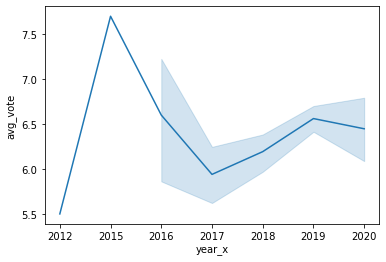

In [188]:
sns.lineplot(df_yearrat["year_x"], df_yearrat["avg_vote"])

In [191]:
df_yearrat = df_yearrat[df_yearrat["type"] != "TV Show"]
df_yearrat["duration"]=df_yearrat["duration"].str.replace(' min','')
df_yearrat["duration"]=df_yearrat["duration"].astype(str).astype(int)
df_yearrat.count()

show_id         487
type            487
title           487
director        487
cast            487
country         487
date_added      487
release_year    487
rating          487
duration        487
listed_in       487
description     487
year_x          487
month           487
year_y          487
genre           487
avg_vote        487
dtype: int64

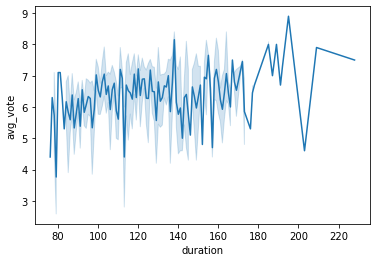

In [216]:
sns.lineplot(df_yearrat["duration"],df_yearrat["avg_vote"])

## Machine Learning
After taking a look at a number of different ways the variables interact, we can now apply machine learning algorithms to see underlying trends in the data. For the purposes of this analysis, we will be making a Decision Tree.

A decision tree is a common technique used to predict a certain value given a few variables to work with. Decision trees are very useful and simple to understand. Basically, at each node there will be a decision that will then split the data into categories, for example a movie with a release year before 2000 or after. 

For this model, we will look at the data to see if we can predict the average rating that a movie will receive. Before we run the model, we must first randomly split the data in order to get a random sample to train our data on by using train_test_split. Another quick note, Decision Trees cannot use continuous data, therefore they dislike any sort of float value. To tackle this issue we have taken the movie ratings and multiplied by 10, so the ratings will now be out of 100 instead of 10.

In [223]:
X = df_yearrat[["release_year","duration"]]
y = df_yearrat["avg_vote"]*10
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.50)

Now that we have our training sets of data, we will then make our Decision tree to fit the data and make predictions. The sklearn library has a very useful DecisionTreeClassifier that will help us do just that.

In [224]:
classifier = DecisionTreeClassifier()
classifier.fit(X_train, y_train)

DecisionTreeClassifier()

Finally now that we have a fitted Decision Tree, we will run the data against our predictions to see hwoo accurate our predictions were using a confusion matrix and a classification report. Thankfully, these are also both available in our sklearn library. To learn more about what these are you can go [here.](https://en.wikipedia.org/wiki/Confusion_matrix)

In [225]:
y_pred = classifier.predict(X_test)
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
              precision    recall  f1-score   support

        21.0       0.00      0.00      0.00         1
        23.0       0.00      0.00      0.00         1
        24.0       0.00      0.00      0.00         1
        26.0       0.00      0.00      0.00         1
        28.0       0.00      0.00      0.00         1
        29.0       0.00      0.00      0.00         1
        31.0       0.00      0.00      0.00         1
        32.0       0.00      0.00      0.00         1
        34.0       0.00      0.00      0.00         2
        37.0       0.00      0.00      0.00         0
        38.0       0.00      0.00      0.00         1
        39.0       0.00      0.00      0.00         2
        41.0       0.00      0.00      0.00         3
        42.0       0.00      0.00      0.00         7
        43.0       0.00      0.00      0.00         2
        44.0   

C:\Users\Jonah\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jonah\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Conclusion
As you can see from the above output from our confusion matrix, the data was not a good sign of our actual values, showing that based off of this model, the release year of a movie and how long it is have no correlation with how well the audience perceives it. For future expansion upon this model, I would suggest looking at non numerical indicators, such as looking at genre or the maturity rating of a movie to see if either of those have an effect on the average rating.